In [17]:
#IMPORT IMPORTANCE LIBRARY
import spacy
from gensim.models import FastText

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from category_encoders import MEstimateEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [18]:
df = pd.read_csv('C:/Users/admin/Documents/Data Science/Project/BOOK_RECOMMENDER/2. wrangling_data/wrangled_book_data.csv')

In [19]:
df.head()

,Unnamed: 0,img,price,discount,sale_quantities,describe,seller,seller_star,seller_reviews_quantity,seller_follow,...,authentic,publishing_company,publish_date,cover_type,num_of_pages,publisher,rating star,rating_quantity,book_length,book_width
0,0,https://salt.tikicdn.com/cache/750x750/ts/prod...,74000.0,0.32,5000.0,“Việc nghĩ ra một bài toán vô cùng khó và việc...,Tiki,4.7,54000000.0,4924000.0,...,Có,Nhã Nam,2019-05-01 00:00:00,Bìa mềm,396.0,Nhà Xuất Bản Hội Nhà Văn,4.8,3447.0,20.5,14.0
1,1,https://salt.tikicdn.com/cache/750x750/ts/prod...,49000.0,0.35,5000.0,Từng Bước Nở Hoa Sen\nKhông nhơ cũng không sạc...,Tiki,4.7,54000000.0,4924000.0,...,Có,Saigon Books,2018-09-04 10:55:04,Bìa mềm,120.0,Nhà Xuất Bản Hồng Đức,5.0,830.0,20.5,13.0
2,2,https://salt.tikicdn.com/cache/750x750/ts/prod...,81100.0,0.29,939.0,"Thai giáo, xét theo nghĩa rộng là: Trong thời ...",Tiki,4.7,54000000.0,4924000.0,...,Có,Minh Long,2022-08-08 00:00:00,Bìa mềm,256.0,Nhà Xuất Bản Phụ Nữ,4.8,41.0,23.0,17.0
3,3,https://salt.tikicdn.com/cache/750x750/ts/prod...,114000.0,0.31,864.0,“Cách đối xử tốt nhất với một người là gì?\nCó...,Tiki,4.7,54000000.0,4924000.0,...,Có,Sea Books,2023-01-01 00:00:00,Bìa mềm,448.0,Nhà Xuất Bản Thanh Niên,4.7,92.0,20.5,14.5
4,4,https://salt.tikicdn.com/cache/750x750/ts/prod...,109000.0,0.27,5000.0,Thắng hạng mục sách hư cấu của Goodreads.\nĐượ...,Tiki,4.7,54000000.0,4924000.0,...,Có,Nhã Nam,2021-08-01 00:00:00,Bìa mềm,424.0,Nhà Xuất Bản Hội Nhà Văn,5.0,1822.0,20.5,14.0


In [20]:
#PRE-TRAIN MODEL TO USE FOR NLP OF VIETNAMESE
model_path = 'C:/Users/admin/Documents/Data Science/nlp/vnmodel/cc.vi.300.bin'
nlp = spacy.load('vi_core_news_lg')
fasttext_model = FastText.load_fasttext_format(model_path)

C:\Users\admin\AppData\Local\Temp\ipykernel_18672\1986974896.py:3: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  fasttext_model = FastText.load_fasttext_format(model_path)


In [21]:
#FUNCTION TO SEE INFO OF COLS
def info_df(df):
    info = []
    for i in df.columns:
        info.append([i, df[i].dtypes, df[i].nunique(), df[i].isna().sum(), round(100 * df[i].isna().sum()/ len(df[i]),2)])
    return pd.DataFrame(info, columns = ['col', 'dtype', 'nunique', 'na', 'na_percent (%)']).sort_values(by = 'dtype')

#FUNCTION TO PROCESSING AND VECTORIZING TEXT DATA - describe
def preprocessing_vectorizing(text):
    filtered_token = []
    for i in nlp(text.lower()):
        if not i.is_punct and not i.is_stop:
            filtered_token.append(i)
    v = [fasttext_model.wv[token.text] for token in filtered_token]
    return np.mean(v, axis = 0)

#FUNCTION TO CLASSIFY COLS OF DATAFRAME (USE FOR MACHINE LEARNING PIPELINE)
def classify_cols(X):
    num_col = list(X.select_dtypes(['float64','int64','int32']).columns)
    highcar_cat_col = [i for i in X.columns if i not in num_col and X[i].nunique() > 10]
    lowcar_cat_col = [i for i in X.columns if i not in num_col and X[i].nunique() <= 10]
    return num_col, highcar_cat_col, lowcar_cat_col

In [22]:
info_df(df)

,col,dtype,nunique,na,na_percent (%)
0,Unnamed: 0,int64,1975,0,0.00
20,rating_quantity,float64,630,141,7.14
19,rating star,float64,16,141,7.14
17,num_of_pages,float64,409,276,13.97
21,book_length,float64,46,458,23.19
9,seller_follow,float64,101,0,0.00
8,seller_reviews_quantity,float64,94,0,0.00
22,book_width,float64,44,459,23.24
4,sale_quantities,float64,1034,19,0.96
3,discount,float64,56,177,8.96


In [23]:
#VECTORIZING TEXT DATA
df['wv_describe'] = df['describe'].map(preprocessing_vectorizing)

In [24]:
#CALCULATE DISTANCE SIMILARITY
wv_matrix = np.stack(np.array(df['wv_describe']))
distance = 1 - cosine_similarity(wv_matrix)
vals = df['book_name'].tolist()
sl_df = pd.DataFrame(distance, columns = vals, index = vals)
sl_df = sl_df.round(3)

In [26]:
sl_df

,Phía Sau Nghi Can X (Tái Bản 2019),Từng Bước Nở Hoa Sen,Thai Giáo Theo Chuyên Gia - 280 Ngày Mỗi Ngày Đọc 1 Trang,Muối – Sự Hồi Sinh Nơi Sâu Thẳm Vụn Vỡ,Thư Viện Nửa Đêm,Bố Con Cá Gai (Tái Bản 2019),Trí Tuệ Do Thái (Tái Bản),Content Bạc Tỷ (Tái bản 2022),Dạy Con Làm Giàu (Tập 1) - Để Không Có Tiền Vẫn Tạo Ra Tiền - Cha Giàu Cha Nghèo (Tái Bản),Search Inside Yourself – Tìm kiếm bên trong bạn (Tái bản),...,Nghiên Cứu Phân Tâm Học,Bước Đệm Vững Chắc Vào Đời - Bác Sĩ Riêng Của Bé Yêu (Tái Bản 2020),Trái Tim Độc Ác (Trinh Thám),Michelle Obama - Chất Michelle (Bìa Cứng) (Tái Bản),Da Thịt Trong Cuộc Chơi,Điệp Viên Hoàn Hảo X6 (Bìa Mềm),Nụ hôn tinh nghịch,Cuộc Hành Hương Nội Tại,Kỷ Luật Là Sức Mạnh,Homecoming - Hồi Sinh Đứa Trẻ Bên Trong Bạn
Phía Sau Nghi Can X (Tái Bản 2019),0.000,0.159,0.171,0.166,0.302,0.248,0.211,0.240,0.253,0.226,...,0.169,0.203,0.147,0.198,0.206,0.182,0.180,0.160,0.182,0.228
Từng Bước Nở Hoa Sen,0.159,-0.000,0.164,0.116,0.260,0.212,0.174,0.200,0.264,0.164,...,0.157,0.151,0.146,0.160,0.168,0.168,0.179,0.073,0.178,0.154
Thai Giáo Theo Chuyên Gia - 280 Ngày Mỗi Ngày Đọc 1 Trang,0.171,0.164,0.000,0.164,0.251,0.241,0.121,0.127,0.186,0.146,...,0.079,0.056,0.128,0.113,0.100,0.240,0.105,0.135,0.104,0.150
Muối – Sự Hồi Sinh Nơi Sâu Thẳm Vụn Vỡ,0.166,0.116,0.164,-0.000,0.288,0.213,0.188,0.226,0.291,0.226,...,0.164,0.179,0.166,0.191,0.188,0.226,0.212,0.117,0.179,0.182
Thư Viện Nửa Đêm,0.302,0.260,0.251,0.288,0.000,0.357,0.202,0.223,0.262,0.190,...,0.206,0.265,0.251,0.162,0.163,0.220,0.214,0.234,0.185,0.208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Điệp Viên Hoàn Hảo X6 (Bìa Mềm),0.182,0.168,0.240,0.226,0.220,0.277,0.204,0.251,0.256,0.182,...,0.196,0.212,0.207,0.144,0.169,-0.000,0.203,0.169,0.202,0.193
Nụ hôn tinh nghịch,0.180,0.179,0.105,0.212,0.214,0.272,0.129,0.134,0.129,0.138,...,0.089,0.108,0.145,0.108,0.113,0.203,-0.000,0.150,0.102,0.150
Cuộc Hành Hương Nội Tại,0.160,0.073,0.135,0.117,0.234,0.219,0.122,0.118,0.233,0.123,...,0.106,0.119,0.116,0.114,0.117,0.169,0.150,-0.000,0.125,0.114
Kỷ Luật Là Sức Mạnh,0.182,0.178,0.104,0.179,0.185,0.299,0.104,0.113,0.132,0.114,...,0.065,0.115,0.137,0.111,0.084,0.202,0.102,0.125,-0.000,0.157


In [27]:
df.columns

Index(['Unnamed: 0', 'img', 'price', 'discount', 'sale_quantities', 'describe',
       'seller', 'seller_star', 'seller_reviews_quantity', 'seller_follow',
       'book_name', 'detail_cate', 'large_cate', 'authentic',
       'publishing_company', 'publish_date', 'cover_type', 'num_of_pages',
       'publisher', 'rating star', 'rating_quantity', 'book_length',
       'book_width', 'wv_describe'],
      dtype='object')

In [28]:
X = df.loc[:,['price', 'detail_cate', 'large_cate']]
y = df['sale_quantities']

In [30]:
num_col, highcar_cat_col, lowcar_cat_col = classify_cols(X)

In [31]:
#BUILD A COLUMNS TRANSFORMER TO PREPROCESSING DATA BEFORE USING IT FOR MACHINE LEARNING
num_tfmer = Pipeline(steps = [
    ('impute', SimpleImputer(strategy = 'median')),
    ('scaling', StandardScaler())
])

lowcar_tfmer = Pipeline(steps = [
    ('impute', SimpleImputer(strategy = 'most_frequent')),
    ('encode', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'))
])

highcar_tfmer = Pipeline(steps = [
    ('impute', SimpleImputer(strategy = 'most_frequent')),
    ('encode', MEstimateEncoder()),
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer(transformers = [
    ('num', num_tfmer, num_col),
    ('high', highcar_tfmer, highcar_cat_col),
    ('low', lowcar_tfmer, lowcar_cat_col)
])

In [32]:
X_pp = preprocessor.fit_transform(X, y)

c:\Users\admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

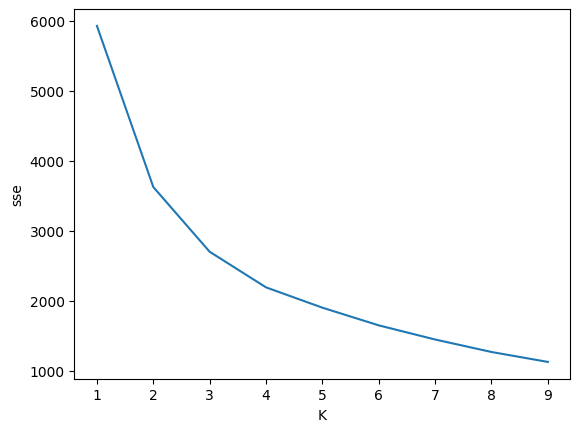

In [33]:
#FIND BEST K-CLUSTER
sse = []
k_range = range(1,10)
for i in k_range:
    km = KMeans(n_clusters = i)
    km.fit_predict(X_pp)
    sse.append(km.inertia_)
plt.xlabel('K')
plt.ylabel('sse')
plt.plot(k_range, sse)


In [34]:
#CLUSTERING
km = KMeans(n_clusters = 7)
df['clusters'] = km.fit_predict(X_pp)

c:\Users\admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [48]:
#FUNCTION TO CHOOSE BEST MATCHED BOOK BASED ON CLUSTER AND DISTANCE SIMILARITY
def choose_similar_book(book_name):
    cluster = int(df.loc[df['book_name'] == book_name]['clusters'])
    cluster_matches = df.loc[df['clusters'] == cluster]['book_name'].tolist()
    cosine_matches = list(sl_df.loc[cluster_matches][book_name].sort_values(ascending = True)[:5].index)
    return cosine_matches

In [43]:
#SAVE RESULTS TO CSV
df.to_csv('full_info_df.csv')
sl_df.to_csv('similarity_df.csv')